In [128]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
from tensorflow import keras
from keras.layers import Reshape, Conv2DTranspose, PReLU
from keras.utils import to_categorical, plot_model
from keras.layers import Concatenate
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.image import resize
from scipy.linalg import sqrtm
import math
from tqdm.notebook import tqdm
import tensorflow as tf
from IPython.display import clear_output, HTML
import glob
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential, Model
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping
import visualkeras
from keras.initializers import RandomNormal
from keras.layers import LeakyReLU, GlobalMaxPooling2D, GlobalAveragePooling2D
import numpy as np

In [129]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
df = pd.read_csv('emnist-letters-train.csv', delimiter=',', header=None)

In [130]:
df.rename(columns={0: 'labels'}, inplace=True)

In [131]:
df

,labels,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99035,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99036,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99037,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99038,-1,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174


In [133]:
# Separate labels from pixel values
labels = df['labels']
pixels = df.drop(columns=['labels'])

# Mapping dictionary
mapping = {-1: 63, 1: 97, 2: 98, 3: 99, 4: 100, 5: 101, 6: 102, 7: 103, 8: 104, 9: 105, 10: 106, 11: 107, 12: 108, 13: 109, 14: 110, 15: 111, 16: 112, 17: 113, 18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24: 120, 25: 121, 26: 122, 27: 123}

# Apply label mapping
mapped_labels = labels.map(mapping)

# Normalize pixel values
normalized_pixels = pixels / 255.0

# Combine the mapped labels and normalized pixel values
normalized_df = pd.concat([mapped_labels, normalized_pixels], axis=1)
normalized_df.columns = ['labels'] + list(normalized_pixels.columns)

# Save normalized dataset to a new CSV file
normalized_df.to_csv('normalized_emnist_words.csv', index=False)

   labels    1    2    3    4    5    6    7    8    9  ...  775  776  777  \
0     119  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     103  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     112  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     111  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     119  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

   778  779  780  781  782  783  784  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 785 columns]


In [134]:
normalized_df

,labels,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99035,114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
99036,120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
99037,115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
99038,63,0.682353,0.682353,0.682353,0.682353,0.682353,0.682353,0.682353,0.682353,0.682353,...,0.682353,0.682353,0.682353,0.682353,0.682353,0.682353,0.682353,0.682353,0.682353,0.682353


In [120]:
# Separate labels and pixel values
labels = df.iloc[:, 0].values
df.iloc[:, 1:].values.reshape(-1, 28, 28)

# images = pixels.reshape(-1, 28, 28)

# # Normalize pixel values to [0, 1] range
# images = images.astype(np.float32) / 255.0

# #Number of Labels
# labels = to_categorical(labels)

# num_classes = labels.shape[1]

# print("Number of classes:", num_classes)


ValueError: Must have equal len keys and value when setting with an iterable

In [119]:
df

,labels,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,w,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,g,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,p,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,o,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,w,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99035,r,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99036,x,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99037,s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99038,?,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174


In [104]:
images.shape

(99040, 28, 28)

In [105]:
print(images[100].min())
print(images[100].max())

0.0
1.0


In [106]:
import tensorflow as tf

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
print(dataset)
# Shuffle, batch, and prefetch the dataset
batch_size = 64  # Adjust batch size as needed
dataset = dataset.shuffle(buffer_size=len(images))
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

<TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(27,), dtype=tf.float32, name=None))>


In [107]:
images.shape

(99040, 28, 28)

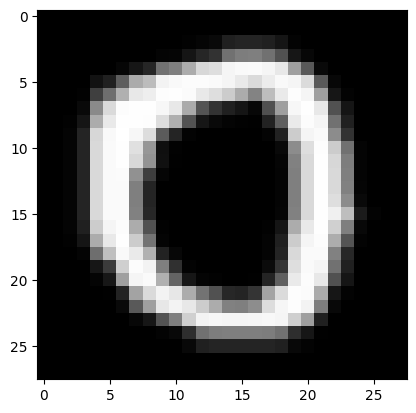

In [108]:
def show_image_np(data, index):
    img = data[index]
    plt.imshow(img, cmap='gray')
    plt.show()
show_image_np(images, 3)

In [109]:
mapping = {-1:63, 1: 97, 2: 98, 3: 99, 4: 100, 5: 101, 6: 102, 7: 103, 8: 104, 9: 105, 10: 106, 11: 107, 12: 108, 13: 109, 14: 110, 15: 111, 16: 112, 17: 113, 18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24:120, 25: 121, 26: 122, 27: 123}
df.labels = df.labels.map(mapping)
df.labels = df.labels.astype('int').apply(chr)

In [110]:
df.labels.value_counts()

labels
?    10240
y     3453
k     3438
e     3437
x     3437
t     3436
q     3435
p     3430
i     3428
z     3427
h     3424
w     3423
v     3422
u     3419
r     3419
c     3419
l     3415
o     3408
j     3402
m     3402
d     3398
b     3396
a     3396
f     3394
s     3392
g     3385
n     3365
Name: count, dtype: int64

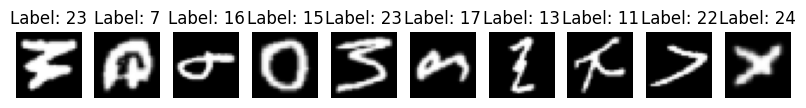

In [111]:
import matplotlib.pyplot as plt

# Display a few normalized images
def show_images(images, labels, num_images=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {np.argmax(labels[i])}')
        plt.axis('off')
    plt.show()

show_images(images, labels)

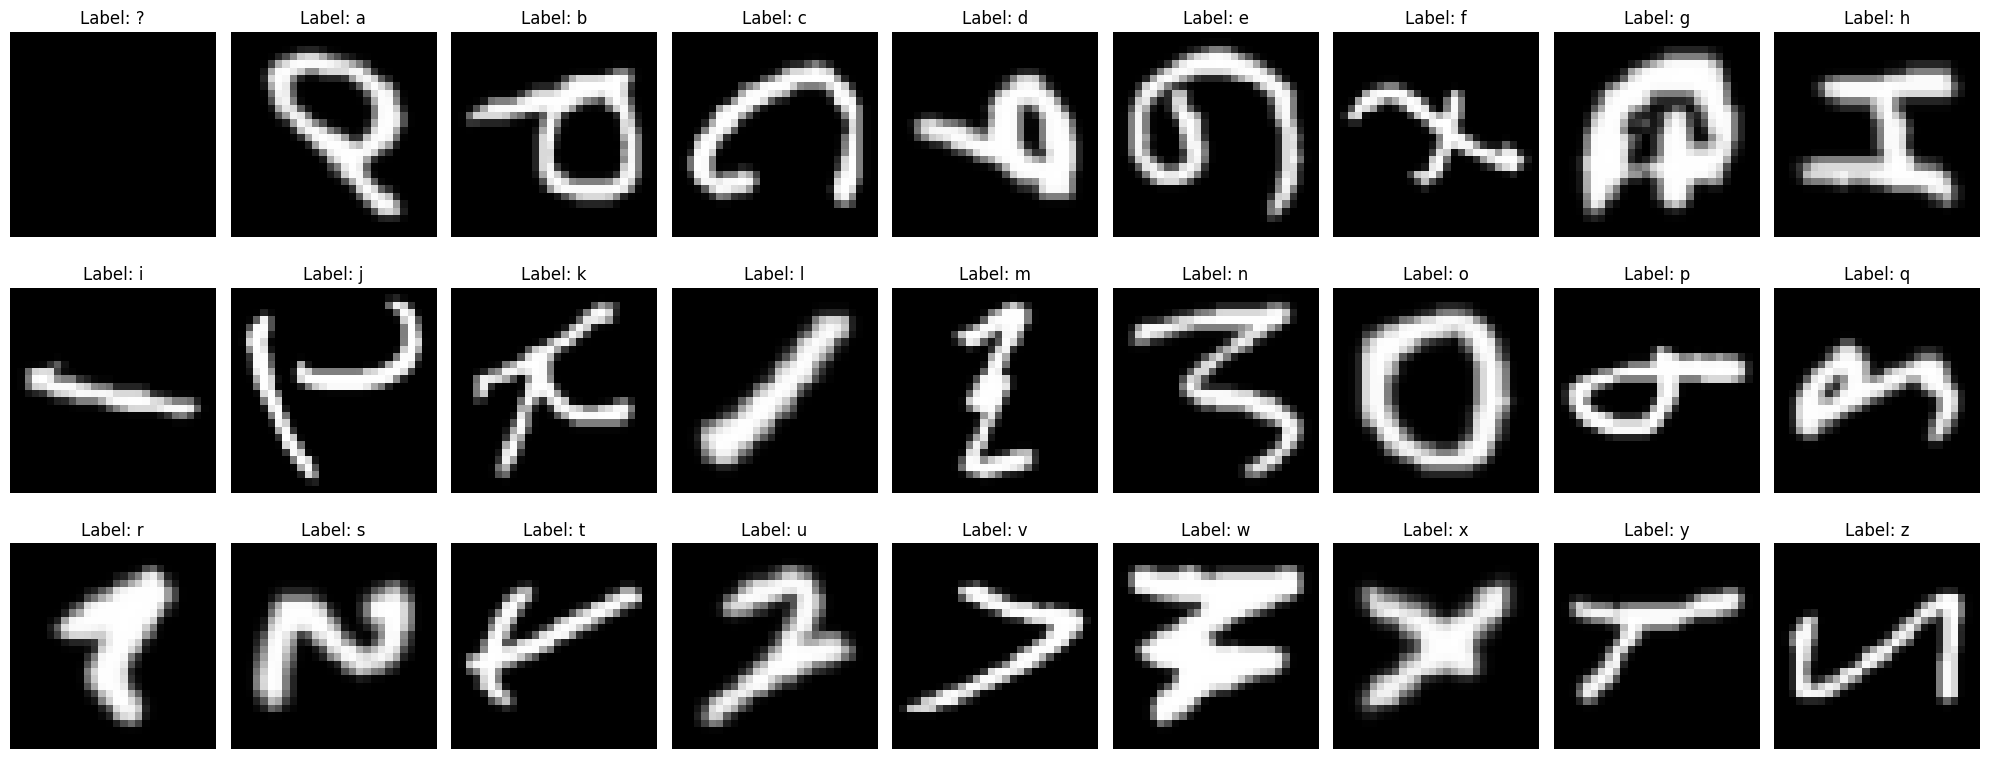

In [112]:
# Get unique labels (assuming you want the first 26 unique labels)
labels = df.iloc[:, 0].unique()
labels = np.sort(labels)

# Create the plot with sufficient subplots
fig, axes = plt.subplots(3, 9, figsize=(20, 8))  # Adjusted to 3 rows and 9 columns for demonstration
axes = axes.flatten()

for label, ax in zip(labels, axes):
    # Select the first row for each unique label
    image_data = df[df.iloc[:, 0] == label].iloc[0, 1:].values
    
    # Ensure the data is in numeric format
    image_data = np.array(image_data, dtype=np.float32)
    
    # Reshape the flat array into a 28x28 image
    image = image_data.reshape(28, 28)
    
    # Display the image
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

# Hide any remaining empty subplots (if any)
for ax in axes[len(labels):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

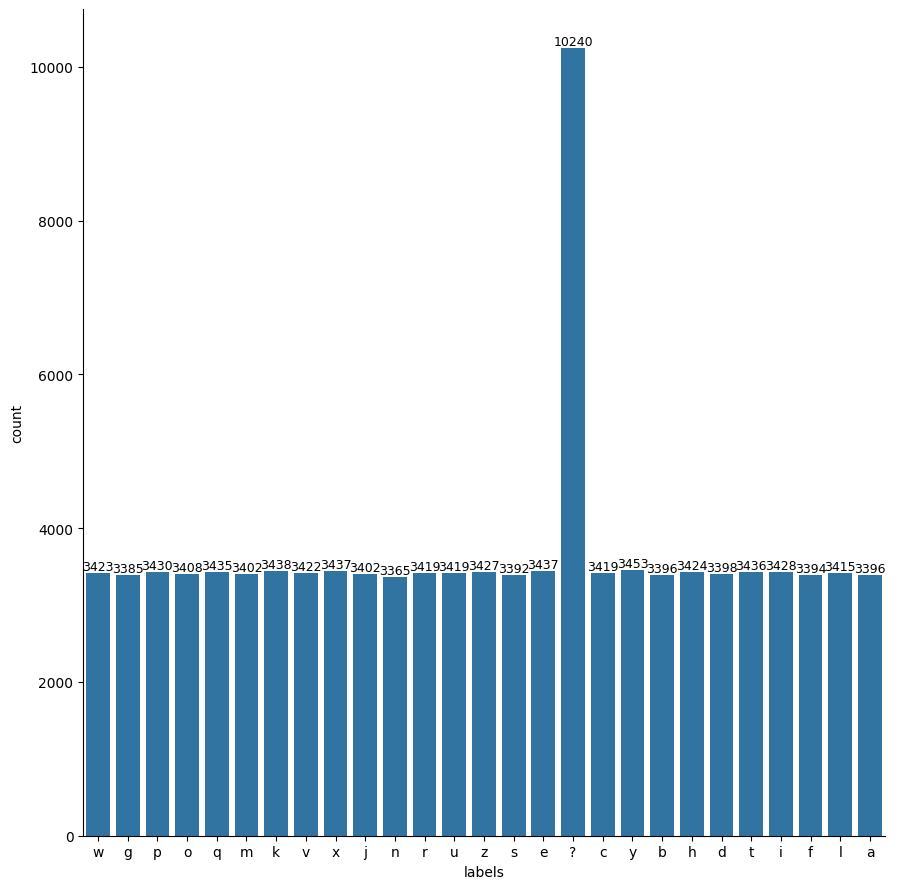

In [113]:
# Create the catplot
g = sns.catplot(x=df.labels, kind="count", data=df, height=9)

ax = g.ax  

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height,  
            f'{int(height)}',  
            ha='center', va='bottom',  
            fontsize=9)  

plt.show()

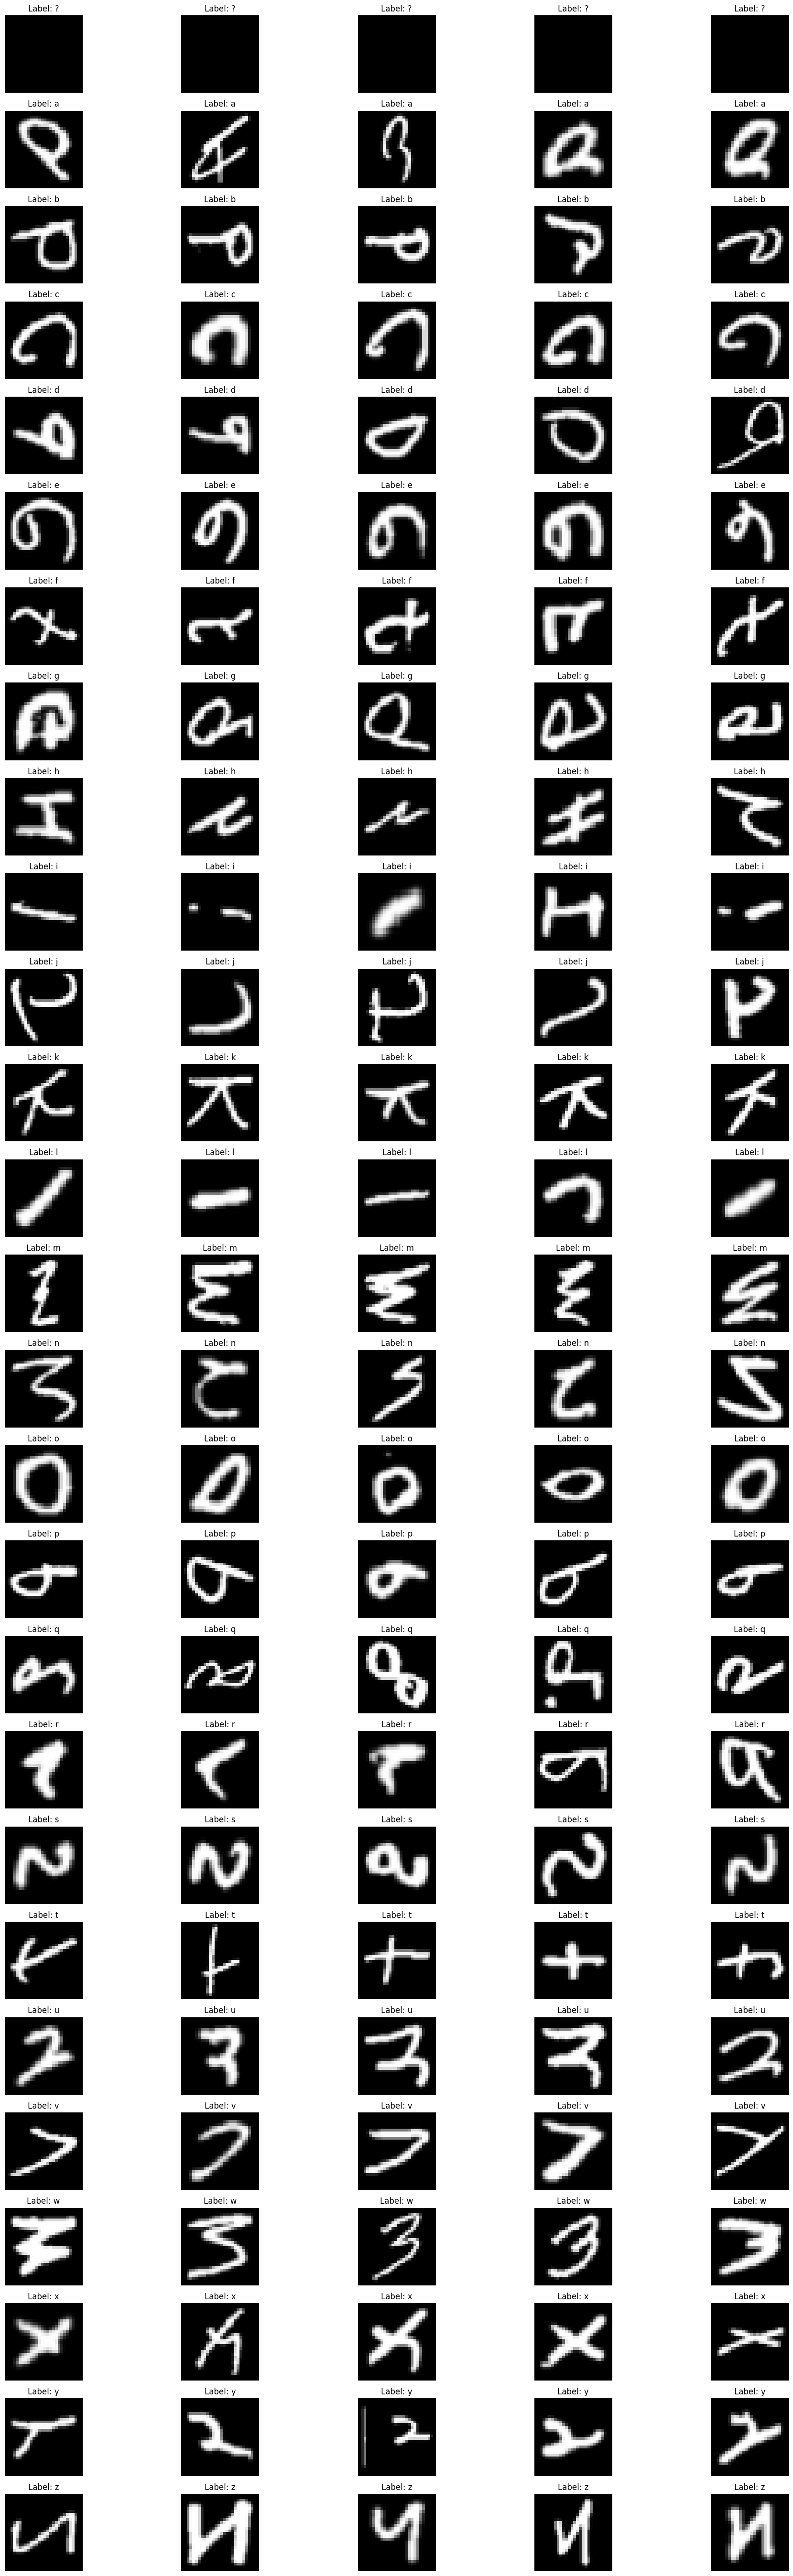

In [114]:
# Number of images per label
num_images_per_label = 5

# Create the plot with sufficient subplots
fig, axes = plt.subplots(len(labels), num_images_per_label, figsize=(20, len(labels) * 2))
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate

# Counter for current axis
ax_index = 0

for label in labels:
    # Filter rows for the current label
    label_df = df[df.iloc[:, 0] == label]
    
    # Loop through up to 10 images for the current label
    for i in range(min(num_images_per_label, len(label_df))):
        image_data = label_df.iloc[i, 1:].values
        
        # Ensure the data is in numeric format
        image_data = np.array(image_data, dtype=np.float32)
        
        # Reshape the flat array into a 28x28 image
        image = image_data.reshape(28, 28)
        
        # Display the image
        axes[ax_index].imshow(image, cmap='gray')
        axes[ax_index].set_title(f'Label: {label}')
        axes[ax_index].axis('off')
        
        # Move to the next axis
        ax_index += 1

# Hide any remaining empty subplots (if any)
for ax in axes[ax_index:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [115]:
print("Max: ", np.max(df.iloc[:, 1:]))
print("Min: ", np.min(df.iloc[:, 1:]))

Max:  255
Min:  0
